Updated 1/6/2022.

In [1]:
from scipy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 3.1.1

Here are 5-year averages of the worldwide temperature anomaly as compared to the 1951-1980 average (source: NASA).

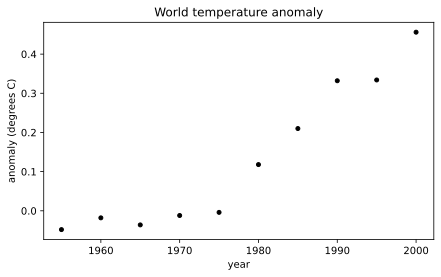

In [3]:
year = np.arange(1955,2005,5)
y = np.array([ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ])

fig,ax = subplots()
ax.scatter(year,y,color="k",label="data")
xlabel("year")
ylabel("anomaly (degrees C)")
title("World temperature anomaly");

A polynomial interpolant can be used to fit the data. Here we build one using a Vandermonde matrix. First, though, we express time as decades since 1950, as it improves the condition number of the matrix. 

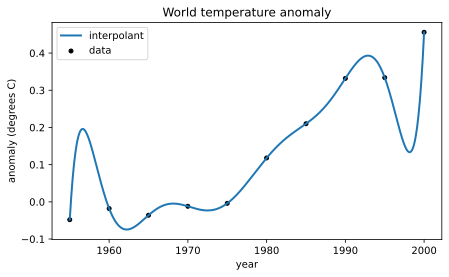

In [4]:
t = (year-1950)/10
V = np.vander(t)
c = solve(V,y)

p = poly1d(c)
tt = np.linspace(1955,2000,500)
ax.plot(tt,p((tt-1950)/10),label="interpolant")
ax.legend();
fig

As you can see, the interpolant does represent the data, in a sense. However it's a crazy-looking curve for the application. Trying too hard to reproduce all the data exactly is known as _overfitting_.

# Example 3.1.2

Here are the 5-year temperature averages again.

In [5]:
year = np.arange(1955,2005,5)
y = np.array([ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ])
t = (year-1950)/10

The standard best-fit line results from using a linear polynomial that meets the least squares criterion. 

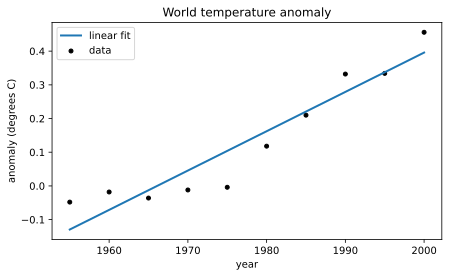

In [6]:
V = [ [t[i],1] for i in range(t.size) ]    # Vandermonde-ish matrix
c,res,rank,sv = lstsq(V,y,rcond=None)

fig,ax = subplots()
ax.scatter(year,y,color="k",label="data")

p = poly1d(c)
tt = np.linspace(1955,2000,500)
ax.plot(tt,p((tt-1950)/10),label="linear fit")

xlabel("year")
ylabel("anomaly (degrees C)")
title("World temperature anomaly");
ax.legend();

If we use a global cubic polynomial, the points are fit more closely.

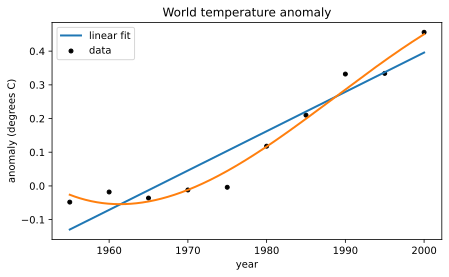

In [7]:
V = [ [t[i]**3,t[i]**2,t[i],1] for i in range(t.size) ]    # Vandermonde-ish matrix
c,res,rank,sv = lstsq(V,y,rcond=None)

p = poly1d(c)
ax.plot(tt,p((tt-1950)/10),label="cubic fit")
fig

If we were to continue increasing the degree of the polynomial, the residual at the data points would get smaller, but overfitting would increase.

# Example 3.1.3

Finding numerical approximations to $\pi$ has fascinated people for millenia. One famous formula is

$$ \frac{\pi^2}{6} = 1 + \frac{1}{2^2} + \frac{1}{3^2} + \cdots. $$


Say $s_k$ is the sum of the first  terms of the series above, and $p_k = \sqrt{6s_k}$. Here is a fancy way to compute these sequences in a compact code.

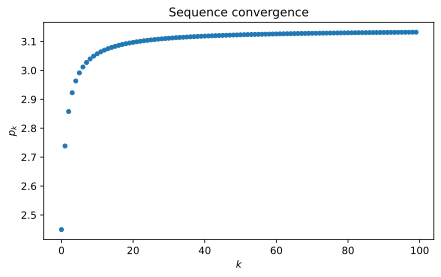

In [8]:
a = np.array([1/(k+1)**2 for k in range(100)])
s = np.cumsum(a)        # cumulative summation
p = np.sqrt(6*s)

plot(range(100),p,"o")
xlabel("$k$") 
ylabel("$p_k$") 
title("Sequence convergence");

This graph suggests that $p_k\to \pi$ but doesn't give much information about the rate of convergence. Let $\epsilon_k=|\pi-p_k|$ be the sequence of errors. By plotting the error sequence on a log-log scale, we can see a nearly linear relationship.

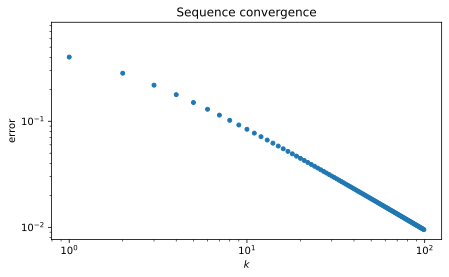

In [9]:
ep = abs(pi-p)    # error sequence
loglog(range(100),ep,"o")
xlabel("$k$") 
ylabel("error") 
title("Sequence convergence");

This suggests a power-law relationship where $\epsilon_k\approx a k^b$, or $\log \epsilon_k \approx b (\log k) + \log a$.

In [10]:
V = [ [1,np.log(k+1)] for k in range(100) ]     # fitting matrix
c = lstsq(V,np.log(ep),rcond=None)[0]           # coefficients of linear fit
print(c)

[-0.18237525 -0.96741032]


In terms of the parameters $a$ and $b$ used above, we have 

In [11]:
a,b = np.exp(c[0]),c[1]
print("b:",b)

b: -0.9674103233127624


It's tempting to conjecture that $b\to -1$ asymptotically. Here is how the numerical fit compares to the original convergence curve. 

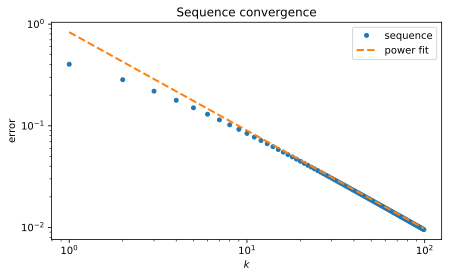

In [12]:
loglog(range(100),ep,"o",label="sequence")
k = np.arange(1,100)
plot(k,a*k**b,"--",label="power fit")
xlabel("$k$");  ylabel("error"); 
legend(); title("Sequence convergence");

# Example 3.2.1

Because the functions $\sin^2(t)$, $\cos^2(t)$, and $1$ are linearly dependent, we should find that the following matrix is somewhat ill-conditioned.

In [13]:
t = np.linspace(0,3,400)
A = np.array([ [ np.sin(t)**2,np.cos((1+1e-7)*t)**2,1 ] for t in t ])
kappa = cond(A)
print(kappa)

18253225.423408035


Now we set up an artificial linear least squares problem with a known exact solution that actually makes the residual zero.

In [14]:
x = np.array([1.,2,1])
b = A@x

Using backslash to find the solution, we get a relative error that is about $\kappa$ times machine epsilon.

In [15]:
x_BS = lstsq(A,b,rcond=None)[0]
print("observed error:",norm(x_BS-x)/norm(x))
print("max error:",kappa/2**52)

observed error: 6.641899324506693e-11
max error: 4.0530302277481745e-09


If we formulate and solve via the normal equations, we get a much larger relative error. With $\kappa^2\approx 10^{14}$, we may not be left with more than about 2 accurate digits.

In [16]:
N = A.T@A
x_NE = solve(N,A.T@b)
print("observed error:",norm(x_NE-x)/norm(x))
print("digits:",-np.log10(norm(x_NE-x)/norm(x)))

observed error: 0.014430750140516358
digits: 1.840711092785969


# Example 3.3.1

We can access both the thin and full forms of the QR factorization. Thin is the default (we use the `numpy` version here, not the `scipy` version).

In [17]:
A = 1.0 + np.floor(9*np.random.rand(6,4))
A.shape

(6, 4)

Here is a standard call:

In [18]:
Q,R = qr(A)
print("Q:",Q)
print("R:",R)

Q: [[-0.22645541  0.52601108  0.42680373  0.2558442 ]
 [-0.67936622 -0.05225276  0.32632149 -0.04726612]
 [-0.33968311 -0.50162646 -0.35748868 -0.27797458]
 [-0.22645541  0.66186825 -0.67093035 -0.20319879]
 [-0.45291081 -0.17069234 -0.27745683  0.6893993 ]
 [-0.33968311  0.04180221  0.23753923 -0.58178918]]
R: [[ -8.83176087 -13.81377982  -5.66138517 -11.54922575]
 [  0.           7.36067165   5.27056139   4.95356133]
 [  0.           0.          -4.8135123    3.84182346]
 [  0.           0.           0.          -3.36422462]]


We can test that $\mathbf{Q}$ has orthonormal columns.

In [19]:
norm(Q.T@Q - np.eye(4))

6.831971689118233e-16

Here's the full or "complete" factorization.

In [20]:
Q,R = qr(A,"complete")
print(Q.shape)

(6, 6)


In [21]:
norm(Q.T@Q - np.eye(6))

1.085754334965903e-15

# Example 3.4.1

We will use Householder reflections to produce a QR factorization of the matrix

In [22]:
A = 1.0 + np.floor(9*np.random.rand(6,4))
m,n = A.shape

Our first step is to introduce zeros below the diagonal in column 1. Define the vector 

In [23]:
z = A[:,0]

Applying the Householder definitions gives us

In [24]:
v = z - norm(z)*np.hstack([1,np.zeros(m-1)])
P = np.eye(m) - (2/np.dot(v,v))*np.outer(v,v)   # reflector

By design we can use the reflector to get the zero structure we seek:

In [25]:
P@z

array([ 1.29614814e+01, -4.44089210e-16,  4.44089210e-16,  0.00000000e+00,
        2.22044605e-16,  1.33226763e-15])

Now we let 

In [26]:
A = P@A
print(A)

[[ 1.29614814e+01  1.03383244e+01  8.64098760e+00  1.12641445e+01]
 [ 5.55111512e-16  5.82063238e+00  1.16720337e+00 -1.14537846e+00]
 [ 4.71844785e-16  5.88042158e+00 -5.55197753e-01  4.23641436e+00]
 [-2.77555756e-16 -1.64947302e+00 -1.19399719e+00 -1.45448205e+00]
 [ 2.77555756e-16  5.41031619e+00  7.08360169e+00  5.92731077e+00]
 [ 4.44089210e-16 -2.76905144e+00 -1.74919494e+00  7.81932316e-01]]


We are set to put zeros into column 2. We must not use row 1 in any way, lest it destroy the zeros we just introduced. To put it another way, we can repeat the process we just did on the smaller submatrix

In [27]:
A[1:,1:]

array([[ 5.82063238,  1.16720337, -1.14537846],
       [ 5.88042158, -0.55519775,  4.23641436],
       [-1.64947302, -1.19399719, -1.45448205],
       [ 5.41031619,  7.08360169,  5.92731077],
       [-2.76905144, -1.74919494,  0.78193232]])

In [28]:
z = A[1:,1]
v = z - norm(z)*np.hstack([1,np.zeros(m-2)])
P = np.eye(m-1) - (2/np.dot(v,v))*np.outer(v,v)

We now apply the reflector to the submatrix.

In [29]:
A[1:,1:] = P@A[1:,1:]
print(A)

[[ 1.29614814e+01  1.03383244e+01  8.64098760e+00  1.12641445e+01]
 [ 5.55111512e-16  1.03980309e+01  4.68037332e+00  4.86126838e+00]
 [ 4.71844785e-16  8.94798958e-16 -5.06844258e+00 -3.48011177e+00]
 [-2.77555756e-16 -1.10117440e-16  7.19793143e-02  7.10022908e-01]
 [ 2.77555756e-16  1.29869083e-15  2.93116445e+00 -1.17232412e+00]
 [ 4.44089210e-16 -6.38483785e-16  3.76062043e-01  4.41559318e+00]]


We need two more iterations of this process.

In [30]:
for j in [2,3]:
    z = A[j:,j]
    v = z - norm(z)*np.hstack([1,np.zeros(m-j-1)])
    P = np.eye(m-j) - (2/np.dot(v,v))*np.outer(v,v)
    A[j:,j:] = P@A[j:,j:]

We have now reduced the original  to an upper triangular matrix using four orthogonal Householder reflections:

In [31]:
R = A
print(R)

[[ 1.29614814e+01  1.03383244e+01  8.64098760e+00  1.12641445e+01]
 [ 5.55111512e-16  1.03980309e+01  4.68037332e+00  4.86126838e+00]
 [ 4.71844785e-16  8.94798958e-16  5.86749000e+00  2.71225274e+00]
 [-2.77555756e-16 -1.10117440e-16  7.73522191e-18  5.11182966e+00]
 [ 2.77555756e-16  1.29869083e-15  7.01126242e-16  0.00000000e+00]
 [ 4.44089210e-16 -6.38483785e-16  1.51588097e-16  3.33066907e-16]]
